In [2]:
import json
import geojson
from PIL import Image
import piexif
import numpy as np
from collections import defaultdict
import shapefile
from shapely.geometry import Point, LineString
from rtree import index
import cv2


In [2]:
corners = [[-83.08489893270443, 30.123174014690044], [-83.08453339472855, 30.12318037458068], [-83.08452791372119, 30.122942291025208], [-83.08489345082155, 30.122935931191176]]

In [12]:
image_path = r"C:\Users\User\Downloads\copy_DJI_20240228083728_0005_D_aligned_xmp.tif"
output_path = r"C:\Users\User\Downloads\Aiman-file-results\temp"
image = cv2.imread(image_path)
image_height, image_width, _ = image.shape
top_left = (corners[1][1], corners[1][0])
bottom_right = (corners[3][1], corners[3][0])

In [10]:

def interpolate_to_gps(x, y):
    lon = top_left[1] + (x / image_width) * (bottom_right[1] - top_left[1])
    lat = top_left[0] + (y / image_height) * (bottom_right[0] - top_left[0])
    return lat, lon

In [15]:
x1, y1 = interpolate_to_gps(corners[0][0], corners[0][1])
x2, y2 = interpolate_to_gps(corners[1][0], corners[1][1])
x3, y3 = interpolate_to_gps(corners[2][0], corners[2][1])
x4, y4 = interpolate_to_gps(corners[3][0], corners[3][1])

In [17]:
import json

# Load your JSON file
json_path = r"C:\Users\User\Downloads\Aiman-file\DJI_20240228084011_0085_D.json"
with open(json_path, 'r') as file:
    data = json.load(file)

# Initialize variables to find the extents
min_x = float('inf')
min_y = float('inf')
max_x = float('-inf')
max_y = float('-inf')

# Iterate through the detections to find the minimum and maximum coordinates
for detection in data['detections']:
    box = detection['box']
    x1, y1 = box['x1'], box['y1']
    x2, y2 = box['x2'], box['y2']

    min_x = min(min_x, x1, x2)
    min_y = min(min_y, y1, y2)
    max_x = max(max_x, x1, x2)
    max_y = max(max_y, y1, y2)

# Print the extents
print(f"Top-left corner: ({min_x}, {min_y})")
print(f"Top-right corner: ({max_x}, {min_y})")
print(f"Bottom-left corner: ({min_x}, {max_y})")
print(f"Bottom-right corner: ({max_x}, {max_y})")


Top-left corner: (0.0, 0.0)
Top-right corner: (5280.0, 0.0)
Bottom-left corner: (0.0, 3956.0)
Bottom-right corner: (5280.0, 3956.0)


In [3]:
def get_angle(corners):
    """
    Calculate the correct rotation angle from corners
    """
    # Get the main edges
    edge1 = [corners[1][0] - corners[0][0], corners[1][1] - corners[0][1]]
    edge2 = [corners[3][0] - corners[0][0], corners[3][1] - corners[0][1]]
    
    # Calculate lengths
    len1 = np.sqrt(edge1[0]**2 + edge1[1]**2)
    len2 = np.sqrt(edge2[0]**2 + edge2[1]**2)
    
    # Use the longer edge for angle calculation
    if len1 > len2:
        dx, dy = edge1
    else:
        dx, dy = edge2
    
    angle = np.arctan2(dy, dx)
    return angle

corners = [[-83.08490226226006, 30.123817184960654], [-83.08453685334257, 30.12382354268575], [-83.08453137416528, 30.12358554475479], [-83.08489678220786, 30.123579187086264]]

print(get_angle(corners))

0.017397177146435655


In [20]:
import pandas as pd

In [3]:
df = pd.read_csv(r"C:\Users\User\Downloads\1880_image_details.csv")

In [5]:
df.head()

,image_name,corners,gsd,image_width,image_height
0,DJI_20250307112525_0066_D_CAMERA12_LA.JPG,"[[-83.16446549315401, 30.250503519065333], [-8...",0.000448,8064,6048
1,DJI_20250307112619_0067_D_CAMERA12_LA.JPG,"[[-83.1644820952984, 30.251570276647477], [-83...",0.000486,8064,6048
2,DJI_20250307112653_0068_D_CAMERA12_LA.JPG,"[[-83.16314248685867, 30.25303646118143], [-83...",0.000473,8064,6048
3,DJI_20250307112712_0069_D_CAMERA12_LA.JPG,"[[-83.16343240357156, 30.252448038825353], [-8...",0.000493,8064,6048
4,DJI_20250307112730_0070_D_CAMERA12_LA.JPG,"[[-83.1634283441402, 30.251552465436436], [-83...",0.000483,8064,6048


In [6]:
df2 = pd.read_csv(r"C:\Users\User\Downloads\1880_image_coordinates_new.csv", )

In [16]:
# a  = df2['elevation'] - df2['elevation'].iloc[0]
# b = df2['updated_elevations'] = df2['relative_altitude'] - df2['updated_elevations']
c = df2['gsd'] = (df2['sensor_width'] * df2['updated_elevations']) / (df2['focal_length'] * df2['width'])

In [18]:
df['gsd']  = c

In [19]:
df.head()

,image_name,corners,gsd,image_width,image_height
0,DJI_20250307112525_0066_D_CAMERA12_LA.JPG,"[[-83.16446549315401, 30.250503519065333], [-8...",0.000486,8064,6048
1,DJI_20250307112619_0067_D_CAMERA12_LA.JPG,"[[-83.1644820952984, 30.251570276647477], [-83...",0.000473,8064,6048
2,DJI_20250307112653_0068_D_CAMERA12_LA.JPG,"[[-83.16314248685867, 30.25303646118143], [-83...",0.000493,8064,6048
3,DJI_20250307112712_0069_D_CAMERA12_LA.JPG,"[[-83.16343240357156, 30.252448038825353], [-8...",0.000483,8064,6048
4,DJI_20250307112730_0070_D_CAMERA12_LA.JPG,"[[-83.1634283441402, 30.251552465436436], [-83...",0.000448,8064,6048


In [52]:
def gsd_correcter(cord_csv, image_csv, new_detail_csv):
    
    image_csv = pd.read_csv(image_csv)
    cord_csv = pd.read_csv(cord_csv)
    cord_csv.columns = cord_csv.columns.str.strip()
    image_csv.columns = image_csv.columns.str.strip()
    print(image_csv.columns)
    print(cord_csv.columns)

    # Rename column to match for merging
    cord_csv.rename(columns={'image': 'image_name'}, inplace=True)

    # Merge and update GSD values
    image_details_updated = image_csv.drop(columns=['gsd']).merge(
        cord_csv[['image_name', 'gsd']], on='image_name', how='left'
    )
    image_details_updated.to_csv(new_detail_csv, index=False)

In [53]:
gsd_correcter(r"C:\Users\User\Downloads\forest-rk\1906_image_coordinates_new.csv", 
              r"C:\Users\User\Downloads\forest-rk\1906_image_details.csv", 
              r"C:\Users\User\Downloads\forest-rk\1906_image_details_new.csv"
              )

Index(['image_name', 'corners', 'gsd', 'image_width', 'image_height'], dtype='object')
Index(['image', 'lat', 'lon', 'relative_altitude', 'camera_model', 'width',
       'height', 'sensor_width', 'focal_length', 'elevation', 'offset',
       'updated_elevations', 'gsd'],
      dtype='object')


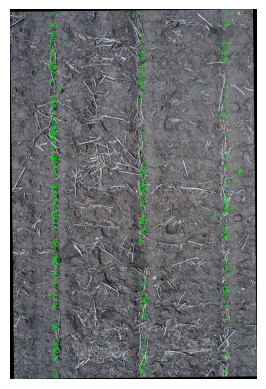

True

In [1]:
import json
import cv2
import matplotlib.pyplot as plt

# Load image
image_path = r"C:\Users\User\Downloads\aiman-task\set_2_23_aligned_xmp.tif"  # replace with your image path
json_path = r"C:\Users\User\Downloads\aiman-task\jsons\set_2_23.json"   # replace with your JSON path

image = cv2.imread(image_path)

# Load JSON data
with open(json_path, 'r') as f:
    data = json.load(f)

# Draw bounding boxes
for det in data['detections']:
    box = det['box']
    x1, y1 = int(box['x1']), int(box['y1'])
    x2, y2 = int(box['x2']), int(box['y2'])

    # Draw rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Optionally, put label
    label = f"{det['name']} {det['confidence']:.2f}"
    cv2.putText(image, label, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Show result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Save output
cv2.imwrite('output_image.jpg', image)


In [1]:
import json
import os
import rasterio
from rasterio.windows import Window

def split_images_and_jsons(input_folder, output_folder, tile_width, tile_height, overlap):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(input_folder):
        if filename.endswith(('.tif', '.tiff', '.jpg', '.JPG')):
            image_path = os.path.join(input_folder, filename)
            json_path = os.path.join(input_folder, filename.rsplit('.', 1)[0] + '.json')
            
            if not os.path.exists(json_path):
                continue
            
            with open(json_path, "r") as f:
                json_data = json.load(f)
            
            with rasterio.open(image_path) as src:
                file_name = os.path.splitext(filename)[0]
                width, height = src.width, src.height
                step_x, step_y = tile_width - overlap, tile_height - overlap
                num_cols = (width - overlap + step_x - 1) // step_x
                num_rows = (height - overlap + step_y - 1) // step_y
                
                for row in range(int(num_rows)):
                    for col in range(int(num_cols)):
                        left, upper = col * step_x, row * step_y
                        right, lower = left + tile_width, upper + tile_height
                        
                        if right > width:
                            right = width
                        if lower > height:
                            lower = height
                        
                        window_width = right - left
                        window_height = lower - upper
                        window = Window(left, upper, window_width, window_height)
                        
                        part = src.read(window=window)
                        window_transform = rasterio.windows.transform(window, src.transform)
                        
                        meta = src.meta.copy()
                        meta.update({
                            "height": window_height,
                            "width": window_width,
                            "transform": window_transform
                        })
                        
                        # Prepare tile JSON
                        tile_json = {
                            "ImageHeight": window_height,
                            "ImageWidth": window_width,
                            "ImagePath": f"{file_name}_{row}_{col}.tif",
                            "Image_center": json_data.get("Image_center", [0, 0]),  # keep original or recalculate if needed
                            "gsd": json_data.get("gsd", 0.001),
                            "detections": []
                        }
                        
                        # Process detections for this tile
                        for detection in json_data.get("detections", []):
                            box = detection["box"]
                            x1, y1 = box["x1"], box["y1"]
                            x2, y2 = box["x2"], box["y2"]
                            
                            # Check if box overlaps tile
                            if x2 >= left and x1 <= right and y2 >= upper and y1 <= lower:
                                new_x1 = max(x1 - left, 0)
                                new_y1 = max(y1 - upper, 0)
                                new_x2 = min(x2 - left, window_width)
                                new_y2 = min(y2 - upper, window_height)
                                
                                new_detection = {
                                    "name": detection["name"],
                                    "box": {
                                        "x1": new_x1,
                                        "y1": new_y1,
                                        "x2": new_x2,
                                        "y2": new_y2
                                    },
                                    "confidence": detection.get("confidence", 1.0)
                                }
                                tile_json["detections"].append(new_detection)
                        
                        # Save only tiles that have detections
                        if len(tile_json["detections"]) > 0:
                            output_filename = f"{output_folder}/{file_name}_{row}_{col}.tif"
                            with rasterio.open(output_filename, "w", **meta) as dest:
                                dest.write(part)
                            
                            json_output_filename = f"{output_folder}/{file_name}_{row}_{col}.json"
                            with open(json_output_filename, "w") as json_out:
                                json.dump(tile_json, json_out, indent=4)
                        
                        print(f"Processed tile {row}_{col} for {filename}")

if __name__ == "__main__":
    input_folder = r"C:\Users\User\Downloads\Compressed\10 images\10 images_results\cleaned_jsons"
    output_folder = r"C:\Users\User\Downloads\Compressed\10 images\10 images_results\cleaned_jsons_tiles"
    tile_width = 1600
    tile_height = 1600
    overlap = 0

    split_images_and_jsons(input_folder, output_folder, tile_width, tile_height, overlap)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:327: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Processed tile 0_0 for DJI_20250421085819_0003_D_LA.JPG
Processed tile 0_1 for DJI_20250421085819_0003_D_LA.JPG
Processed tile 0_2 for DJI_20250421085819_0003_D_LA.JPG
Processed tile 0_3 for DJI_20250421085819_0003_D_LA.JPG
Processed tile 1_0 for DJI_20250421085819_0003_D_LA.JPG
Processed tile 1_1 for DJI_20250421085819_0003_D_LA.JPG
Processed tile 1_2 for DJI_20250421085819_0003_D_LA.JPG
Processed tile 1_3 for DJI_20250421085819_0003_D_LA.JPG
Processed tile 2_0 for DJI_20250421085819_0003_D_LA.JPG
Processed tile 2_1 for DJI_20250421085819_0003_D_LA.JPG
Processed tile 2_2 for DJI_20250421085819_0003_D_LA.JPG
Processed tile 2_3 for DJI_20250421085819_0003_D_LA.JPG
Processed tile 0_0 for DJI_20250421085843_0004_D_LA.JPG
Processed tile 0_1 for DJI_20250421085843_0004_D_LA.JPG
Processed tile 0_2 for DJI_20250421085843_0004_D_LA.JPG
Processed tile 0_3 for DJI_20250421085843_0004_D_LA.JPG
Processed tile 1_0 for DJI_20250421085843_0004_D_LA.JPG
Processed tile 1_1 for DJI_20250421085843_0004_D

In [2]:
import cv2
import json
import numpy as np
import os

def plot_detections_dual(image_path, json_path, output_path):
    """
    Plots both original boxes (green) and merged detection boxes (red) on the same image.
    
    Args:
        image_path: Path to the input image
        json_path: Path to the JSON file containing detections
        output_path: Path where the output image will be saved
    """
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image from {image_path}")
    
    # Load the JSON data
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Get the detections
    detections = data.get('Image_detections', [])
    
    # Define colors (BGR format for OpenCV)
    MERGED_BOX_COLOR = (0, 0, 255)      # Red for merged boxes
    ORIGINAL_BOX_COLOR = (0, 255, 0)    # Green for original boxes
    
    # Counter for boxes
    merged_count = 0
    original_count = 0
    
    # Plot each detection
    for det in detections:
        # Plot the merged detection box (in red)
        x1 = int(det['box']['x1'])
        y1 = int(det['box']['y1'])
        x2 = int(det['box']['x2'])
        y2 = int(det['box']['y2'])
        
        cv2.rectangle(img, (x1, y1), (x2, y2), MERGED_BOX_COLOR, 3)
        merged_count += 1
        
        # Add confidence score if available
        if 'confidence' in det:
            label = f"{det['name']} ({det['confidence']:.2f})"
            cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.6, MERGED_BOX_COLOR, 2)
        
        # Plot original boxes if they exist (in green)
        if 'original_boxes' in det:
            for orig_box in det['original_boxes']:
                ox1 = int(orig_box['x1'])
                oy1 = int(orig_box['y1'])
                ox2 = int(orig_box['x2'])
                oy2 = int(orig_box['y2'])
                
                cv2.rectangle(img, (ox1, oy1), (ox2, oy2), ORIGINAL_BOX_COLOR, 2)
                original_count += 1
    
    # Add legend
    legend_y = 30
    cv2.putText(img, "Legend:", (10, legend_y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    cv2.putText(img, f"Red = Merged boxes ({merged_count})", (10, legend_y + 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, MERGED_BOX_COLOR, 2)
    cv2.putText(img, f"Green = Original boxes ({original_count})", (10, legend_y + 60), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, ORIGINAL_BOX_COLOR, 2)
    
    # Save the output image
    success = cv2.imwrite(output_path, img)
    if not success:
        raise IOError(f"Failed to write image to {output_path}")
    
    print(f"Successfully saved annotated image to {output_path}")
    print(f"Plotted {merged_count} merged detections (red) and {original_count} original boxes (green)")


def plot_detections_separate(image_path, json_path, output_dir):
    """
    Creates two separate images: one with only original boxes and one with only merged boxes.
    
    Args:
        image_path: Path to the input image
        json_path: Path to the JSON file containing detections
        output_dir: Directory where output images will be saved
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image from {image_path}")
    
    # Create copies for different visualizations
    img_merged = img.copy()
    img_original = img.copy()
    
    # Load the JSON data
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    detections = data.get('Image_detections', [])
    
    # Colors
    MERGED_BOX_COLOR = (0, 0, 255)      # Red
    ORIGINAL_BOX_COLOR = (0, 255, 0)    # Green
    
    merged_count = 0
    original_count = 0
    
    # Plot merged boxes on first image
    for det in detections:
        x1 = int(det['box']['x1'])
        y1 = int(det['box']['y1'])
        x2 = int(det['box']['x2'])
        y2 = int(det['box']['y2'])
        
        cv2.rectangle(img_merged, (x1, y1), (x2, y2), MERGED_BOX_COLOR, 3)
        merged_count += 1
        
        # Add label with confidence
        if 'confidence' in det:
            label = f"{det['name']} ({det['confidence']:.2f})"
            cv2.putText(img_merged, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.6, MERGED_BOX_COLOR, 2)
    
    # Plot original boxes on second image
    for det in detections:
        if 'original_boxes' in det:
            for orig_box in det['original_boxes']:
                ox1 = int(orig_box['x1'])
                oy1 = int(orig_box['y1'])
                ox2 = int(orig_box['x2'])
                oy2 = int(orig_box['y2'])
                
                cv2.rectangle(img_original, (ox1, oy1), (ox2, oy2), ORIGINAL_BOX_COLOR, 2)
                original_count += 1
                
                # Add label
                cv2.putText(img_original, det['name'], (ox1, oy1-5), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, ORIGINAL_BOX_COLOR, 2)
    
    # Add count info to images
    cv2.putText(img_merged, f"Merged Detections: {merged_count}", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, MERGED_BOX_COLOR, 2)
    cv2.putText(img_original, f"Original Detections: {original_count}", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, ORIGINAL_BOX_COLOR, 2)
    
    # Save both images
    merged_path = os.path.join(output_dir, "merged_detections.jpg")
    original_path = os.path.join(output_dir, "original_detections.jpg")
    
    cv2.imwrite(merged_path, img_merged)
    cv2.imwrite(original_path, img_original)
    
    print(f"Saved merged detections to: {merged_path}")
    print(f"Saved original detections to: {original_path}")
    print(f"Total: {merged_count} merged boxes, {original_count} original boxes")


# Example usage:
if __name__ == "__main__":
    # Example 1: Plot both on same image
    plot_detections_dual(
        image_path=r"C:\Users\User\Downloads\momna_check\DJI_20250604141153_0047_D_LA.JPG",
        json_path=r"C:\Users\User\Downloads\momna_check\jsons_result\cleaned_jsons\DJI_20250604141153_0047_D_LA.json",
        output_path="output_dual.jpg"
    )
    
    # # Example 2: Plot separately
    # plot_detections_separate(
    #     image_path="DJI_20250604141153_0047_D_LA.JPG",
    #     json_path="detections.json",
    #     output_dir="output_separate/"
    # )

Successfully saved annotated image to output_dual.jpg
Plotted 236 merged detections (red) and 378 original boxes (green)
